In [1]:
# Step 1: Install kagglehub
!pip install kagglehub --quiet

# Step 2: Import kagglehub
import kagglehub

# Step 3: Download the dataset
# This will download and extract it automatically
dataset_path = kagglehub.dataset_download("imbikramsaha/food11")

print("Path to dataset files:", dataset_path)

# Step 4: Check folder structure
import os
os.listdir(dataset_path)

100%|██████████| 519M/519M [00:03<00:00, 141MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imbikramsaha/food11/versions/1


['food11']

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset paths
base_dir = "/root/.cache/kagglehub/datasets/imbikramsaha/food11/versions/1/food11"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Image parameters
IMG_SIZE = (224, 224)  # EfficientNetB0 input size
BATCH_SIZE = 32

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # 10% of training set for validation
)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # 90% for training
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # 10% for validation
)

# Test generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 8910 images belonging to 11 classes.
Found 990 images belonging to 11 classes.
Found 1100 images belonging to 11 classes.


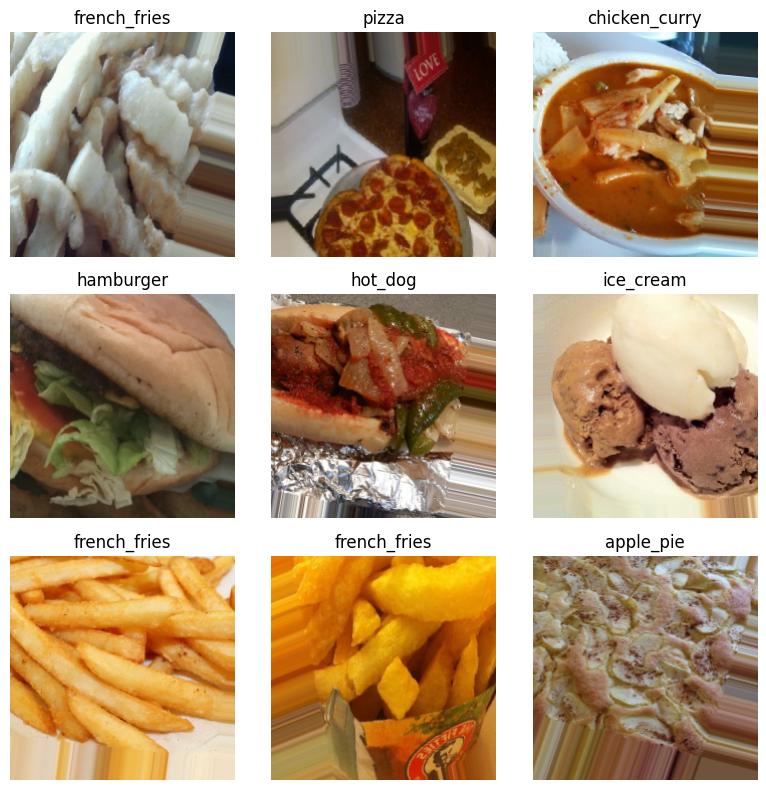

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_generator)

# Number of samples to display
num_samples = 9

plt.figure(figsize=(8, 8))
for i in range(num_samples):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_index = np.argmax(labels[i])
    class_label = list(train_generator.class_indices.keys())[class_index]
    plt.title(class_label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
# Step 0: Mixed precision for faster training on T4
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# Step 1: Import required layers and callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Step 2: Load MobileNetV2 base model
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = True  # fine-tune top layers

# Step 3: Build custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(11, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Step 4: Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 5: Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    "mobilenetv2_food11.keras",
    monitor='val_loss',
    save_best_only=True
)

# Step 6: Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.4825 - loss: 1.7321 - val_accuracy: 0.6424 - val_loss: 1.3955
Epoch 2/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 130s 466ms/step - accuracy: 0.7760 - loss: 0.7246 - val_accuracy: 0.6778 - val_loss: 1.4128
Epoch 3/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 128s 459ms/step - accuracy: 0.8248 - loss: 0.5565 - val_accuracy: 0.7071 - val_loss: 1.3468
Epoch 4/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 129s 461ms/step - accuracy: 0.8683 - loss: 0.4064 - val_accuracy: 0.7505 - val_loss: 1.0105
Epoch 5/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 128s 457ms/step - accuracy: 0.8841 - loss: 0.3498 - val_accuracy: 0.7717 - val_loss: 0.9481
Epoch 6/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 129s 461ms/step - accuracy: 0.9040 - loss: 0.2836 - val_accuracy: 0.7737 - val_loss: 0.9807
Epoch 7/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 127s 457ms/step - accuracy: 0.9242 - loss: 0.2308 - val_accuracy: 0.7859 - val_loss: 0.9671
Epoch 8/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 129s 463ms/step - accuracy: 0.9247 - lo

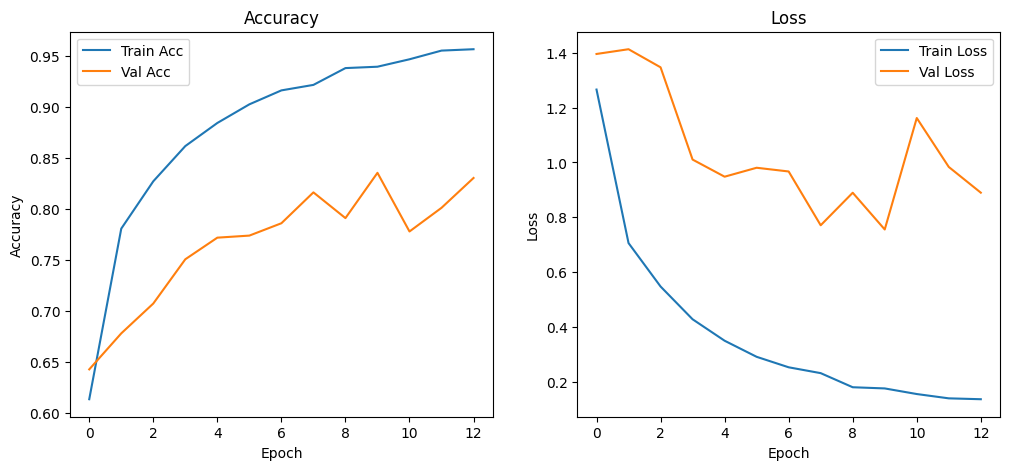

In [5]:
import matplotlib.pyplot as plt

# 1. Plot accuracy and loss curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [6]:

# 2. Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 766ms/step - accuracy: 0.8242 - loss: 0.7128
Test Accuracy: 0.8500, Test Loss: 0.6146


In [7]:

# 3. Save the model
model.save("mobilenetv2_food11.keras")
print("Model saved as mobilenetv2_food11.keras")

Model saved as mobilenetv2_food11.keras
